In [1]:
import os
import sys
import math
import rich
import torch
import random
import numpy  as np
import pandas as pd
import seaborn  as sns
import torch.nn as nn
import torch.autograd as autograd
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm 
from dotenv   import load_dotenv
from datasets import load_dataset
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset
from torch.nn.parameter import Parameter
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Load DATA_PATH from .env file
load_dotenv()
data_path  = os.getenv("DATA_PATH")
model_path = os.getenv("MODEL_PATH")
cebab_path = os.getenv("CEBAB_PATH")

In [4]:
if cebab_path not in sys.path:
    sys.path.append(cebab_path)

from sparse_model import SubnetLinear_Mask, insert_sparse_mask, set_sparse_index, setup_seed

In [5]:
# Load the model and tokenizer
model_path = model_path+'/distilbert-base-uncased_0.7_joint.pth'
model = torch.load(model_path, map_location=torch.device('cpu'))
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Ensure to set the model in evaluation mode
model.eval()
seed = 42
max_len = 512
batch_size = 8
lambda_XtoC = 5.
is_aux_logits = False
num_labels = 5  #label的个数
num_each_concept_classes = 3  #每个concept有几个类
num_concept_labels = 4
train_split = "train_exclusive"
test_split = "test"
val_split  = "validation"
CEBaB = load_dataset("CEBaB/CEBaB")

In [6]:
class MyDataset(Dataset):
    # Split = train/dev/test
    def __init__(self, split, skip_class = "no majority"):
        self.data = CEBaB[split]
        self.labels = self.data["review_majority"]
        self.text = self.data["description"]
        
        self.food_aspect = self.data["food_aspect_majority"]
        self.ambiance_aspect = self.data["ambiance_aspect_majority"]
        self.service_aspect = self.data["service_aspect_majority"]
        self.noise_aspect =self.data["noise_aspect_majority"]
        
        self.map_dict = {"Negative":0, "Positive":1, "unknown":2, "":2,"no majority":2}

        self.skip_class = skip_class
        if skip_class is not None:
            self.indices = [i for i, label in enumerate(self.labels) if label != skip_class]
        else:
            self.indices = range(len(self.labels))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, index):
        text = self.text[self.indices[index]]
        label = int(self.labels[self.indices[index]]) - 1

        # gold labels
        food_concept = self.map_dict[self.food_aspect[self.indices[index]]]
        ambiance_concept = self.map_dict[self.ambiance_aspect[self.indices[index]]]
        service_concept = self.map_dict[self.service_aspect[self.indices[index]]]
        noise_concept = self.map_dict[self.noise_aspect[self.indices[index]]]
        
        concept_labels = [food_concept,ambiance_concept,service_concept,noise_concept]

        encoding = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            truncation=True,
            padding="max_length",
            return_attention_mask=True,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.long),
            "food_concept": torch.tensor(food_concept, dtype=torch.long),
            "ambiance_concept": torch.tensor(ambiance_concept, dtype=torch.long),
            "service_concept": torch.tensor(service_concept, dtype=torch.long),
            "noise_concept": torch.tensor(noise_concept, dtype=torch.long),
            "concept_labels": torch.tensor(concept_labels, dtype=torch.long)
        }

test_dataset = MyDataset(test_split)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): SubnetLinear_Mask(
            (fc): Linear(in_features=768, out_features=768, bias=True)
            (mask_list): ParameterList(
                (0): Parameter containing: [torch.float32 of size 768x768]
                (1): Parameter containing: [torch.float32 of size 768x768]
                (2): Parameter containing: [torch.float32 of size 768x768]
                (3): Parameter containing: [torch.float32 of size 768x768]
            )
          )
          (k_lin): SubnetLinear_Mask(
            (fc): Linear(in_f

In [8]:
ModelXtoCtoY_layer = torch.load(model_path+"/distilbert-base-uncased_0.7_ModelXtoCtoY_layer_joint.pth",
                                map_location=torch.device('cpu')) 

In [9]:
num_epochs = 1
print("Test!")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Test!


In [14]:
# Initialize accumulators
test_accuracy = 0.
concept_test_accuracy = 0.
predicted_labels = np.array([])
true_labels = np.array([])
concept_predicted_labels = np.array([])
concept_true_labels = np.array([])

# Evaluate the model
for epoch in range(num_epochs):  # Added epoch loop
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(test_loader, desc="Evaluating")):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            label = batch["label"].to(device)
            
            food_concept = batch["food_concept"].to(device)
            ambiance_concept = batch["ambiance_concept"].to(device)
            service_concept = batch["service_concept"].to(device)
            noise_concept = batch["noise_concept"].to(device)

            concept_labels = batch["concept_labels"].to(device)
            concept_labels = torch.t(concept_labels)
            concept_labels = concept_labels.contiguous().view(-1)

            XtoC_outputs = []
            XtoY_outputs = []
            for concept_idx in range(num_concept_labels):
                set_sparse_index(model, concept_idx)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                pooled_output = outputs.last_hidden_state.mean(1)

                outputs = ModelXtoCtoY_layer(pooled_output)
                XtoC_outputs.append(outputs[concept_idx + 1])
                XtoY_outputs.extend(outputs[0:1])

            # Predict labels
            predictions = torch.argmax(XtoY_outputs[0], axis=1)
            test_accuracy += torch.sum(predictions == label).item()
            predicted_labels = np.append(predicted_labels, predictions.cpu().numpy())
            true_labels = np.append(true_labels, label.cpu().numpy())

            # Predict concepts
            XtoC_logits = torch.cat(XtoC_outputs, dim=0)
            concept_predictions = torch.argmax(XtoC_logits, axis=1)
            
            # Reshape concept_predictions as in Code Piece 3
            concept_predictions = concept_predictions.view(-1, num_concept_labels)

            # Ensure concept_labels are in the correct shape
            concept_labels = concept_labels.view(-1, num_concept_labels)

            # Compute concept accuracy
            concept_test_accuracy += torch.sum(concept_predictions == concept_labels).item()
            concept_predicted_labels = np.append(concept_predicted_labels, concept_predictions.cpu().numpy().flatten())
            concept_true_labels = np.append(concept_true_labels, concept_labels.cpu().numpy().flatten())
            
            # Print some example texts with their labels and concepts
            if batch_idx < 5:  # Print first 5 batches as examples
                for i in range(len(label)):
                    print("Text:", tokenizer.decode(input_ids[i], skip_special_tokens=True))
                    print("True Label:", label[i].item(), "Predicted Label:", predictions[i].item())
                    print("True Concepts:", concept_labels[i].cpu().numpy(), "Predicted Concepts:", concept_predictions[i].cpu().numpy())
                    print()
            
        test_accuracy /= len(test_dataset)
        num_labels = len(np.unique(true_labels))

        concept_test_accuracy /= len(test_dataset)
        concept_num_true_labels = len(np.unique(concept_true_labels))
        
        macro_f1_scores = []
        for label in range(num_labels):
            label_pred = np.array(predicted_labels) == label
            label_true = np.array(true_labels) == label
            macro_f1_scores.append(f1_score(label_true, label_pred, average='macro'))
            mean_macro_f1_score = np.mean(macro_f1_scores)

        concept_macro_f1_scores = []
        for concept_label in range(concept_num_true_labels):
            concept_label_pred = np.array(concept_predicted_labels) == concept_label
            concept_label_true = np.array(concept_true_labels) == concept_label
            concept_macro_f1_scores.append(f1_score(concept_label_true, concept_label_pred, average='macro'))
            concept_mean_macro_f1_score = np.mean(concept_macro_f1_scores)

    print(f"Epoch {epoch + 1}: Test concept Acc = {concept_test_accuracy*100/num_concept_labels} Test concept Macro F1 = {concept_mean_macro_f1_score*100}")
    print(f"Epoch {epoch + 1}: Test Acc = {test_accuracy*100} Test Macro F1 = {mean_macro_f1_score*100}")

Evaluating:   0%|          | 1/212 [00:09<34:45,  9.88s/it]

Text: limoncello has excellent italian food. so good, that it tastes homemade. the only drawback is that it is so loud in the restaurant.
True Label: 3 Predicted Label: 3
True Concepts: [1 1 1 0] Predicted Concepts: [1 1 1 0]

Text: limoncello has excellent italian food. so good, that it tastes homemade. it wasn't too loud in the restaurant either and was very calming.
True Label: 4 Predicted Label: 3
True Concepts: [1 1 1 2] Predicted Concepts: [1 1 2 0]

Text: limoncello has excellent italian food. so good, that it tastes homemade. service was responsive and fast! the only drawback is that it is so loud in the restaurant.
True Label: 3 Predicted Label: 3
True Concepts: [2 2 2 2] Predicted Concepts: [2 2 2 2]

Text: limoncello has terrible italian food. so bad, that it tastes jarred. the other drawback is that it is so loud in the restaurant.
True Label: 0 Predicted Label: 1
True Concepts: [2 2 2 2] Predicted Concepts: [2 2 2 2]

Text: limoncello has excellent italian food. so good, t

Evaluating:   1%|          | 2/212 [00:19<34:25,  9.83s/it]

Text: pretty pricey - even for an expense account and the mood in the air was slightly disconcerting.
True Label: 1 Predicted Label: 1
True Concepts: [2 2 2 2] Predicted Concepts: [2 2 0 2]

Text: pretty pricey - even for an expense account. i was glad it wasn't one of those places where you had to yell to be heard though.
True Label: 2 Predicted Label: 1
True Concepts: [1 0 1 1] Predicted Concepts: [1 0 1 1]

Text: pretty pricey - even for an expense account. beautiful dining room.
True Label: 3 Predicted Label: 2
True Concepts: [0 2 1 2] Predicted Concepts: [0 2 1 2]

Text: pretty pricey - even for an expense account. too loud and noisy for a business meeting.
True Label: 1 Predicted Label: 1
True Concepts: [1 1 1 1] Predicted Concepts: [1 1 1 1]

Text: i went here for 2010 restaurant week and it was fabulous! the mussel appetizer was amazing! nice, romantic atmosphere. i will definitely be eating here again.
True Label: 4 Predicted Label: 4
True Concepts: [2 2 2 2] Predicted Concept

Evaluating:   1%|▏         | 3/212 [00:29<34:39,  9.95s/it]

Text: i went here for 2010 restaurant week and it was terrible! the mussel appetizer was unappetizing! not nice, unromantic atmosphere. i will definitely not be eating here again.
True Label: 0 Predicted Label: 0
True Concepts: [1 2 1 1] Predicted Concepts: [0 1 1 1]

Text: i went here for 2010 restaurant week and it was fabulous! nice, romantic atmosphere. i will definitely be eating here again.
True Label: 4 Predicted Label: 4
True Concepts: [0 1 1 1] Predicted Concepts: [0 1 1 1]

Text: i went here for 2010 restaurant week and it was fabulous! the mussel appetizer was amazing! i will definitely be eating here again.
True Label: 4 Predicted Label: 4
True Concepts: [0 1 2 2] Predicted Concepts: [0 1 2 2]

Text: we had a great time, good food and great service. the restaurant is one of our favorites in the sacramento area.
True Label: 4 Predicted Label: 4
True Concepts: [2 2 2 2] Predicted Concepts: [2 2 2 2]

Text: we had a great time, bad food but great service. the restaurant is one

Evaluating:   2%|▏         | 4/212 [00:40<34:58, 10.09s/it]

Text: we had a great time, good food. the restaurant is one of our favorites in the sacramento area.
True Label: 4 Predicted Label: 4
True Concepts: [1 2 1 1] Predicted Concepts: [1 2 1 1]

Text: we had a great time, great service. the restaurant is one of our favorites in the sacramento area.
True Label: 4 Predicted Label: 4
True Concepts: [0 1 2 0] Predicted Concepts: [0 1 0 0]

Text: the food was very good and the service was exceptional, but it seemed a bit overpriced to me compared to some of the other upscale pizza places.
True Label: 3 Predicted Label: 3
True Concepts: [2 2 2 2] Predicted Concepts: [2 2 2 2]

Text: the food was very good but the service was not too great to be honest. it seemed a bit overpriced to me compared to some of the other upscale pizza places.
True Label: 2 Predicted Label: 2
True Concepts: [2 2 2 2] Predicted Concepts: [2 2 2 2]

Text: the food wasn't very good, but the service was exceptional. it seemed a bit overpriced to me compared to some of the ot

Evaluating:   2%|▏         | 5/212 [00:50<34:55, 10.12s/it]

Text: good ambiance but too expensive for the small portions!
True Label: 1 Predicted Label: 2
True Concepts: [0 0 0 0] Predicted Concepts: [0 0 0 2]

Text: too expensive and bland for the small portions!
True Label: 1 Predicted Label: 0
True Concepts: [0 2 1 1] Predicted Concepts: [2 0 1 1]

Text: too expensive for the small portions but the noise level as great.
True Label: 2 Predicted Label: 2
True Concepts: [1 2 2 0] Predicted Concepts: [1 2 2 2]

Text: too expensive for the small portions and it looked like it had not been cleaned in months
True Label: 1 Predicted Label: 1
True Concepts: [2 2 2 2] Predicted Concepts: [2 2 2 2]

Text: too expensive for the small portions and so noisy we couldn't hear each other at all!
True Label: 1 Predicted Label: 1
True Concepts: [2 2 2 2] Predicted Concepts: [2 2 2 2]

Text: too expensive!
True Label: 0 Predicted Label: 0
True Concepts: [2 2 0 0] Predicted Concepts: [2 2 0 0]

Text: the food was excellent but the waiters were not very friendly.

Evaluating: 100%|██████████| 212/212 [1:12:44<00:00, 20.59s/it]

Epoch 1: Test concept Acc = 84.82830076968621 Test concept Macro F1 = 86.559210617642
Epoch 1: Test Acc = 63.5287152161042 Test Macro F1 = 76.62706213387115


<Figure size 1200x1200 with 0 Axes>

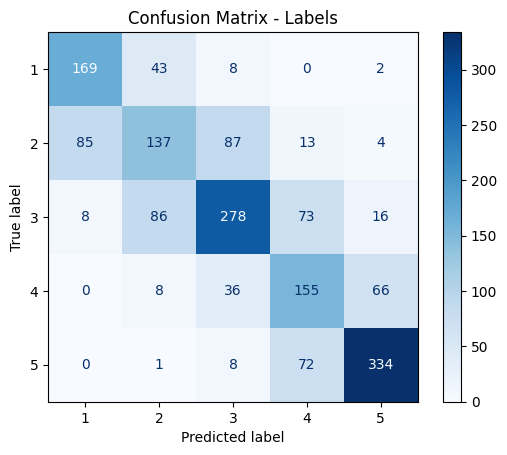

In [22]:
plt.figure(figsize=(6, 6),dpi=200)
cm_labels = confusion_matrix(true_labels, predicted_labels)
disp_labels = ConfusionMatrixDisplay(confusion_matrix=cm_labels, display_labels=[1, 2, 3, 4, 5])
disp_labels.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Labels")
plt.show()

<Figure size 1200x1200 with 0 Axes>

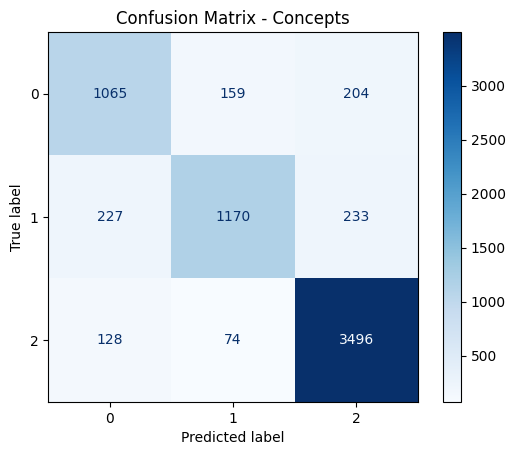

In [24]:
plt.figure(figsize=(6, 6),dpi=200)
cm_concepts = confusion_matrix(concept_true_labels, concept_predicted_labels)
disp_concepts = ConfusionMatrixDisplay(confusion_matrix=cm_concepts)
disp_concepts.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Concepts")
plt.show()